In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models
import torchvision.transforms

import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection

In [2]:
numeros = sklearn.datasets.load_digits()
imagenes = numeros['images']  # Hay 1797 digitos representados en imagenes 8x8
n_imagenes = len(imagenes)
X = imagenes.reshape((n_imagenes, -1)) # para volver a tener los datos como imagen basta hacer data.reshape((n_imagenes, 8, 8))
Y = numeros['target']

scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X).reshape(n_imagenes,8,8)
Y_train = Y
#X_test = scaler.transform(X_test).reshape(n_imagenes/2,8,8)

x_train = torch.autograd.Variable(torch.Tensor(X_train).float())
y_train = torch.autograd.Variable(torch.Tensor(Y_train).long())

x_train = x_train.unsqueeze(1)

In [14]:
# Verifico dimensiones de las capas
print(x_train.size())

n = torch.nn.Conv2d(1, 10, kernel_size=2, stride=1) # in-channels, out-channels, kernel, stride
new_tensor = n(x_train)
print(new_tensor.size())


n = torch.nn.Conv2d(10,7,kernel_size=5)
new_tensor = n(new_tensor)
print(new_tensor.size())

torch.Size([1797, 1, 8, 8])
torch.Size([1797, 10, 7, 7])
torch.Size([1797, 7, 3, 3])


In [9]:
# define el autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=2, stride=1),
            #torch.nn.ReLU(True),
            torch.nn.Conv2d(10,7,kernel_size=5),
            torch.nn.ReLU(True)
        )
        self.decoder = torch.nn.Sequential(             
            torch.nn.ConvTranspose2d(7,10,kernel_size=5),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(10,1,kernel_size=2, stride=1),
            #torch.nn.ReLU(True)
        )
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
# inicializa modelo, loss y optimizador
num_epochs = 100
model = Autoencoder()
distance = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1E-3)

In [11]:
# entrenamiento
epochs = []
losses = []

for epoch in range(num_epochs):
    output = model(x_train)
    loss = distance(output, x_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    
    losses.append(loss.item())
    epochs.append(epoch+1)

Text(0.5, 1.0, 'Loss mínima: 0.1101')

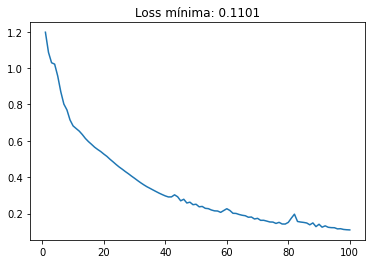

In [12]:
plt.figure()
plt.plot(epochs,losses)
plt.title('Loss mínima: {:.4f}'.format(np.amin(losses)))

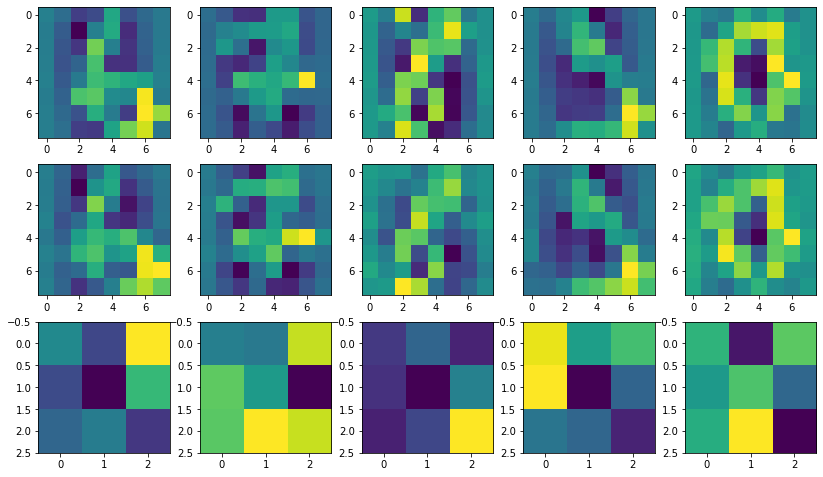

In [13]:
x_transform = model(x_train)
latent_space = model.encoder(x_train)

# muestra los resultados de las cuatro capas de convolucion
plt.figure(figsize=(14,14))
offset = 16
for i in range(5):
    plt.subplot(5,5,i+1) #imagenes originales
    plt.imshow(x_train[i+offset][0].detach().numpy())
    #plt.title(train_loader.dataset.classes[train_loader.dataset.targets[i+offset]] )
    
    j=0 # las imagenes reconstruidas por el autoencoder
    plt.subplot(5,5,(i+1)+5*(j+1))
    plt.imshow(x_transform[i+offset][0].detach().numpy())
    
    j=1 # una de las capas de la representacion latente
    plt.subplot(5,5,(i+1)+5*(j+1))
    plt.imshow(latent_space[i+offset][2].detach().numpy())